In [1]:
import os, shutil
import io
from io import StringIO
import re
import sys
from contextlib import redirect_stdout
from keras import models
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from keras import backend as K

import time

import numpy as np
import scipy.optimize as opt
import scipy.stats as sp
from scipy.stats import kde
import importlib as im
from sklearn import metrics
import csv

# my utilities
import cnn_utilities as cn
import uq_utilities_2 as uq

Using TensorFlow backend.


In [12]:
# LOAD trained models and normalization values
# point est model

mtbd_mean_sd = pd.read_csv("trained_quantile_CNN/cqr_trained_mtbd_normalization_label_mean_sd.csv",
                           index_col=0).to_numpy()


# quantile models
q95_model = models.load_model("trained_quantile_CNN/cqr95_MTBD.hdf5", compile = False)




ERROR! Session/line number was not unique in database. History logging moved to new session 4146


In [13]:

############ checking coverage #################


In [100]:
##########################
# calibration data set ###
##########################
uq_mtbd_cblv_data = pd.read_csv("data_files/labels_and_preds/uq_calibration_mtbd_sets_0to15.cblv.csv",
                            header =None, error_bad_lines = False, index_col = 0).to_numpy()
uq_labels = pd.read_table("data_files/labels_and_preds/uq_calibration_mtbd_sets_0to15_labels.tsv", header = 0).to_numpy()


ERROR! Session/line number was not unique in database. History logging moved to new session 4165


In [101]:
# log R0 sample rate and migration rate

# setting up the data shape params and aux params
train_means = mtbd_mean_sd[0,:]
train_sd = mtbd_mean_sd[1,:]
train_aux_priors_means = train_means[7:,]
train_aux_priors_sd = train_sd[7:,]

num_locs = 5
max_tips = 502


In [103]:
mtbd_subsample_prop = uq_mtbd_cblv_data[:,(max_tips-1) * 7]
mtbd_mu = uq_mtbd_cblv_data[:,(max_tips - 3) * 7]
mtbd_num_tips = cn.get_num_tips(uq_mtbd_cblv_data)

aux_mtbd = np.vstack((mtbd_mu, mtbd_subsample_prop, mtbd_num_tips,
                          uq_labels[:,12], uq_labels[:,13])).transpose()

norm_aux_mtbd = cn.normalize(aux_mtbd, (train_aux_priors_means, train_aux_priors_sd))


# create input tensors
mtbd_treeLocation_tensor, mtbd_prior_tensor = cn.create_data_tensors(data = uq_mtbd_cblv_data, 
                                                                        mu = norm_aux_mtbd[:,0],
                                                                        subsample_prop = norm_aux_mtbd[:,1],
                                                                        num_tips = norm_aux_mtbd[:,2],
                                                                        tmrca = norm_aux_mtbd[:,3],
                                                                        mean_bl = norm_aux_mtbd[:,4],
                                                                        num_locs = num_locs,
                                                                        max_tips = max_tips,
                                                                        cblv_contains_mu_rho = True)




In [104]:
# PREDICT R0, sample rate, migration rate
cnn_norm_preds =  np.array(q95_model.predict([mtbd_treeLocation_tensor, mtbd_prior_tensor]))

uq_normalized_labels = cn.normalize(np.log(uq_labels[:,0:7]), mtbd_mean_sd[:,0:7])

print("done")

done


In [105]:
# holdout a validation set for after calibration
# split calibration prediction dat for conformal prediction interval estimation and validation
uq_num_val = 5000

cal_uq_normalized_labels = uq_normalized_labels[uq_num_val:,:]
cal_norm_preds = cnn_norm_preds[:,uq_num_val:,:]

dj_norm_cqr = uq.get_CQR_constant(cal_norm_preds, cal_uq_normalized_labels, 
                                          inner_quantile=0.95, symmetric = False)


print("done")

done


In [128]:
# function for computing all quantiles for calibration validation and 
# each experiment and populating an output dictionary

# uniform prior boundaries. Use for fair comparison against Bayesian method
prior_bounds = np.array([[2, 8],[0.0001, 0.005], [0.0001, 0.005]])

def get_adj_ci(pred, adj):
    if(len(adj.shape) > 1):
        return np.array((pred[0] + adj[0,:], pred[1] + adj[1,:]))
    else:
        return np.array((pred[0] - adj, pred[1] + adj))

    
def get_cqr_ci(treeloc_tensor, prior_tensor, adj_CQR):
    tm = train_means[0:7]
    tsd = train_sd[0:7]
    
    # PREDICT R0, sample rate, migration rate
    preds = np.array(q95_model.predict([treeloc_tensor, prior_tensor]))
    
    adj_uq = get_adj_ci(preds, adj_CQR)
        
    # denormalize
    adj_lin_uq = np.exp(cn.denormalize(adj_uq, tm, tsd))
    
        
    # set quantiles that extend beyond the prior bounds to the boundary value
    prior_bounds = np.array([[0.9,15],[0.9,15],[0.9,15],[0.9,15],[0.9,15],[0.0001,0.005],[0.0001,0.005]])
    for i in range(prior_bounds.shape[0]):
        # adjust prior violating intervals to boundary value
        too_low_idx = np.where(adj_lin_uq[0,:,i] < prior_bounds[i,0])
        too_high_idx = np.where(adj_lin_uq[1,:,i] > prior_bounds[i,1])
        adj_lin_uq[0,too_low_idx,i] = prior_bounds[i,0]
        adj_lin_uq[1,too_high_idx,i] = prior_bounds[i,1]

    
    return(adj_lin_uq)
    

    
print("done")

done


In [107]:
# get coverages and output files for CQR validation set
uq_val_labels  =  np.exp(cn.denormalize(uq_normalized_labels[:uq_num_val,:], train_means[0:7], train_sd[0:7]))
adj_val_uq = get_cqr_ci(mtbd_treeLocation_tensor[:uq_num_val,:,:], mtbd_prior_tensor[:uq_num_val,:], dj_norm_cqr)

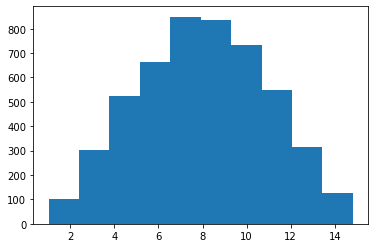

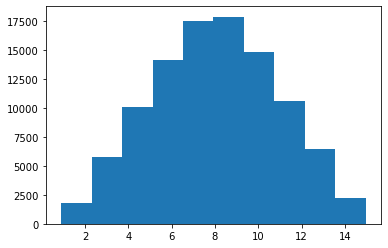

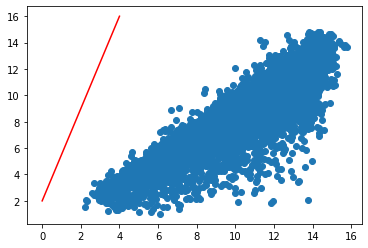

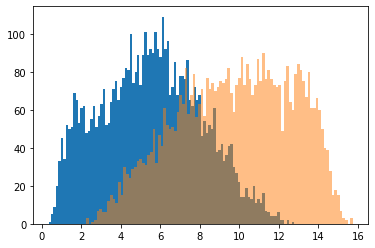

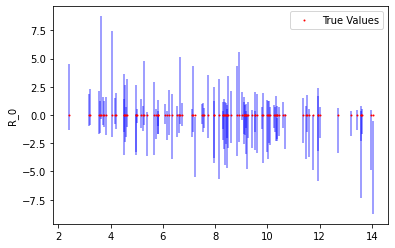

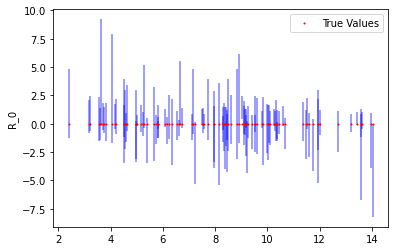

In [108]:
# checking stuff before I'm wrecking stuff

check_preds = np.exp(cn.denormalize(cnn_norm_preds[:,:uq_num_val,:], train_means[0:7], train_sd[0:7]))
plt.hist(uq_val_labels[:,0])
plt.show()

plt.hist(np.exp(cn.denormalize(cal_uq_normalized_labels[:,0], train_means[0], train_sd[0])))
plt.show()
plt.plot(check_preds[1,:,0], uq_val_labels[:,0], 'o')
plt.plot((0,4),(2,16), color = "red")
plt.show()
plt.hist(check_preds[0,:,0], bins = 100)
plt.hist(check_preds[1,:,0], alpha = 0.5, bins = 100)
plt.show()


uq.plot_QI(check_preds[0,0:100,0:1].T, check_preds[1,0:100,:1].T, uq_val_labels[0:100,0:1].T, 
                     param_names = ["R_" + str(i) for i in range(2)])

uq.plot_QI(adj_val_uq[0,0:100,0:1].T, adj_val_uq[1,0:100,:1].T, uq_val_labels[0:100,0:1].T, 
                     param_names = ["R_" + str(i) for i in range(2)])



In [109]:
# check coverage
#before comform
print("before:")
for n in range(adj_val_uq.shape[2]):
    count = 0
    for i in range(adj_val_uq.shape[1]):
        if check_preds[0,i,n] <= uq_val_labels[i,n] <= check_preds[1,i,n]:
            count += 1

    percentage = count / adj_val_uq[:,:,0].shape[1] * 100
    print(percentage)
# after
print("\nafter:")
for n in range(adj_val_uq.shape[2]):
    count = 0
    for i in range(adj_val_uq.shape[1]):
        if adj_val_uq[0,i,n] <= uq_val_labels[i,n] <= adj_val_uq[1,i,n]:
            count += 1

    percentage = count / adj_val_uq[:,:,0].shape[1] * 100
    print(percentage)


before:
94.1
95.19999999999999
94.86
94.98
91.47999999999999
96.84
95.44

after:
95.19999999999999
94.94
94.5
94.8
94.86
94.96
95.16


In [19]:


#####################################
## get coverages from experimente ###
#####################################



ERROR! Session/line number was not unique in database. History logging moved to new session 4151


In [131]:
###############################
## analyze nadaeu 2021 trees ##
###############################
# read cblv data
full_tree_cblv = pd.read_csv("../../real_data_analysis/full_tree_0.5dayUnits_nadeau2021.cblv.csv",
                             header = None, error_bad_lines = False).to_numpy()
A2_tree_cblv = pd.read_csv("../../real_data_analysis/A2_tree_0.5dayUnits_nadeau2021.cblv.csv",
                    header = None, error_bad_lines = False).to_numpy()



In [132]:
# revbayes output
# compute and gather auxilliary prior data
full_tree_subsample_prop = full_tree_cblv[:,(max_tips-1) * 7]
full_tree_mu = full_tree_cblv[:,(max_tips - 3) * 7]
full_tree_num_tips = cn.get_num_tips(full_tree_cblv)

aux_full_tree = np.vstack((full_tree_mu, full_tree_subsample_prop, full_tree_num_tips,
                          192.72, 25.36)).transpose()

norm_aux_full_tree = cn.normalize(aux_full_tree, (train_aux_priors_means, train_aux_priors_sd))

In [133]:
# create input tensors
full_treeLocation_tensor, full_prior_tensor = cn.create_data_tensors(data = full_tree_cblv, 
                                                                        mu = norm_aux_full_tree[:,0],
                                                                        subsample_prop = norm_aux_full_tree[:,1],
                                                                        num_tips = norm_aux_full_tree[:,2],
                                                                        tmrca = norm_aux_full_tree[:,3],
                                                                        mean_bl = norm_aux_full_tree[:,4],
                                                                        num_locs = num_locs,
                                                                        max_tips = max_tips,
                                                                        cblv_contains_mu_rho = True)


a2_tree_subsample_prop = A2_tree_cblv[:,(max_tips-1) * 7]
a2_treep_mu = A2_tree_cblv[:,(max_tips - 3) * 7]
a2_tree_num_tips = cn.get_num_tips(A2_tree_cblv)

aux_a2_tree = np.vstack((a2_treep_mu, a2_tree_subsample_prop, a2_tree_num_tips,
                          109.14, 22.06)).transpose()

norm_aux_a2 = cn.normalize(aux_a2_tree, (train_aux_priors_means, train_aux_priors_sd))


# create input tensors
a2_treeLocation_tensor, a2_prior_tensor = cn.create_data_tensors(data = A2_tree_cblv, 
                                                                    mu = norm_aux_a2[:,0],
                                                                    subsample_prop = norm_aux_a2[:,1],
                                                                    num_tips = norm_aux_a2[:,2],
                                                                    tmrca = norm_aux_a2[:,3],
                                                                    mean_bl = norm_aux_a2[:,4],
                                                                    num_locs = num_locs,
                                                                    max_tips = max_tips,
                                                                    cblv_contains_mu_rho = True)

In [173]:
# make phylodynammic pramater predictions
fulltree_q = get_cqr_ci(full_treeLocation_tensor, full_prior_tensor, dj_norm_cqr)[:,0,0:7]
a2_q = get_cqr_ci(a2_treeLocation_tensor, a2_prior_tensor, dj_norm_cqr)[:,0,0:7]

In [174]:
fulltree_q_a2_q = np.hstack((np.array(fulltree_q).T, np.array(a2_q).T))
df_mtbd_ci = pd.DataFrame(fulltree_q_a2_q, 
                          index = np.concatenate((["R_" + str(i) for i in range(5)], ["sample_rate", "m_rate"])), 
                               columns = ["fulltree_lower_q", "fulltree_upper_q", "A2_lower_q", "A2_upper_q"])
df_mtbd_ci.to_csv('../output/nadeau2021_mtbd_95ci.tsv', sep = "\t", index = True)

In [136]:
a2_q

array([[0.9       , 3.2182912 , 1.24991776, 1.82313602, 2.88469105],
       [3.51583513, 5.39781686, 4.11112323, 3.39781418, 4.87449873]])

In [138]:
fulltree_q

array([[0.9       , 2.16909828, 1.73645946, 1.24575759, 2.42475544],
       [1.98768632, 4.12552657, 3.9663805 , 2.77541435, 3.84654932]])

In [137]:
np.exp(cn.denormalize(q95_model.predict([a2_treeLocation_tensor, a2_prior_tensor]), train_means[0:7], train_sd[0:7]))

array([[[8.07777917e-01, 3.11188743e+00, 1.21762456e+00, 1.76268395e+00,
         2.73291379e+00, 1.57074387e-04, 5.22408826e-04]],

       [[3.39295939e+00, 5.34473089e+00, 4.07488040e+00, 3.35054020e+00,
         4.68917906e+00, 4.00155825e-04, 3.81094927e-03]]])

In [139]:
np.exp(cn.denormalize(q95_model.predict([full_treeLocation_tensor, full_prior_tensor]), train_means[0:7], train_sd[0:7]))

array([[[6.99791867e-01, 2.09738313e+00, 1.69159583e+00, 1.20445040e+00,
         2.29717757e+00, 2.47102752e-04, 4.19909318e-04]],

       [[1.91821821e+00, 4.08495321e+00, 3.93141370e+00, 2.73679985e+00,
         3.70031044e+00, 1.01241339e-03, 1.86634696e-03]]])

In [147]:
print("full tree 95% sampling proportion: delta/mu")
print([0.000247/0.05, 0.001/0.05])
print("""note that Nadeau et al. 2021 estimates for each region and ranges 
from about 0.0025 to 0.12 and is strongly influenced by their informed prior""")

full tree 95% sampling proportion: delta/mu
[0.004939999999999999, 0.02]
note that Nadeau et al. 2021 estimates for each region and ranges 
from about 0.0025 to 0.12 and is strongly influenced by their informed prior


In [154]:
print("migration proportion: m/mu")
print([0.00042/0.05, 0.0019/0.05])
print("this means our CNN thinks that between 1 and 4% of infected individuals travels to one of the other regions")
print("""Our simulations assumed the migration proportion was between: """ )
print([0.0001/0.05, 0.005/0.05])

migration proportion: m/mu
[0.0084, 0.038]
this means our CNN thinks that between 1 and 4% of infected individuals travels to one of the other regions
Our simulations assumed the migration proportion was between: 
[0.002, 0.09999999999999999]


In [153]:
print("""nudaeu's migration rate estimates are in the neighborhood of 0.1 to 10 
and their assumed recovery rate is: 36.5 per year. taking m/mu: """)
print([0.1/36.5, 10/36.5])
print("""Our simulations assumed the migration proportion was between: """ )
print([])

nudaeu's migration rate estimates are in the neighborhood of 0.1 to 10 
and their assumed recovery rate is: 36.5 per year. taking m/mu: 
[0.0027397260273972603, 0.273972602739726]
